In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.cluster import KMeans
from fastdtw import fastdtw
from sklearn.preprocessing import RobustScaler
import glob
import matplotlib.pyplot as plt


entorno = 'local'  # Elegir "VM" o "local" para correr en entorno local
nombre_experimento = 'clusterizacion_dtw'
ventana_input = 12
ventana_output = 2
num_clusters = 20
max_number_clusters = 60


# Configurar entorno
if entorno == 'VM':
    carpeta_datasets = os.path.expanduser('~/buckets/b1/datasets')
    carpeta_exp_base = os.path.expanduser('~/buckets/b1/exp')
elif entorno == 'local':
    carpeta_datasets = 'C:\\Users\\alope\\Desktop\\Trámites\\Maestria Data Science - Universidad Austral\\Laboratorio de implementación 3\\Datos'
    carpeta_exp_base = 'C:\\Users\\alope\\Desktop\\Trámites\\Maestria Data Science - Universidad Austral\\Laboratorio de implementación 3\\Resultados'
else:
    raise Exception("Entorno especificado incorrectamente")

carpeta_exp = os.path.join(carpeta_datasets, nombre_experimento)
if not os.path.exists(carpeta_exp):
    os.makedirs(carpeta_exp)
    
dataset_completo = pd.read_csv(os.path.join(carpeta_datasets, 'df_producto_cliente_completo.csv'))


#Eliminar columnas no utilizadas
dataset_completo.head()
    

,Timestamp,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,...,sku_size,descripcion,mes,quarter,fin_quarter,edad_producto,ventas_cat1,ventas_cat2,ventas_cat3,ventas_familia_producto
0,2017-01-01,10234,20524,0.0,2.0,0.05300,0.05300,HC,VAJILLA,Cristalino,...,500.0,Abrillantador,1,1,0,0,14.31686,4.96628,3.03194,0.25684
1,2017-02-01,10234,20524,NaN,0.0,0.00000,0.00000,HC,VAJILLA,Cristalino,...,500.0,Abrillantador,2,1,0,1,2.14290,0.10339,0.00000,0.00000
2,2017-03-01,10234,20524,0.0,1.0,0.01514,0.01514,HC,VAJILLA,Cristalino,...,500.0,Abrillantador,3,1,1,2,8.59237,2.23835,1.52777,0.04699
3,2017-04-01,10234,20524,NaN,0.0,0.00000,0.00000,HC,VAJILLA,Cristalino,...,500.0,Abrillantador,4,2,0,3,9.18260,4.47157,2.35257,0.00000
4,2017-05-01,10234,20524,NaN,0.0,0.00000,0.00000,HC,VAJILLA,Cristalino,...,500.0,Abrillantador,5,2,0,4,7.79714,0.50130,0.09348,0.00000


In [2]:
# Preparar ventas por producto, cliente, mes
ventas_producto_mes = dataset_completo.groupby(['Timestamp', 'product_id', 'customer_id'])['tn'].sum().reset_index()
ventas_producto_mes

,Timestamp,product_id,customer_id,tn
0,2017-01-01,20001,10001,99.43861
1,2017-01-01,20001,10002,35.72806
2,2017-01-01,20001,10003,143.49426
3,2017-01-01,20001,10004,184.72927
4,2017-01-01,20001,10005,19.08407
...,...,...,...,...
6910867,2019-12-01,21276,10428,0.00000
6910868,2019-12-01,21276,10456,0.00000
6910869,2019-12-01,21276,10462,0.00000
6910870,2019-12-01,21276,10495,0.00000


In [45]:
if not os.path.isfile(os.path.join(carpeta_exp, 'tamaño_series.csv')):
    #Analizar tamaño de las series producto-cliente
    tamaño_series = pd.DataFrame()
    cantidad_productos= len(ventas_producto_mes['product_id'].unique())


    j = 1
    for producto in ventas_producto_mes['product_id'].unique():
        clientes_producto = ventas_producto_mes[ventas_producto_mes['product_id'] == producto]
        cantidad_clientes = len(clientes_producto['customer_id'].unique())
        i= 1
        for cliente in clientes_producto['customer_id'].unique():
            print(f'Procesando cliente {i} de {cantidad_clientes} - Producto {j} de {cantidad_productos}',  end="\r")
            serie_producto_cliente = clientes_producto[clientes_producto['customer_id'] == cliente]
            cantidad_datos_no_nulos = len(serie_producto_cliente[serie_producto_cliente['tn'] != 0])
            tn_dic_2019 = serie_producto_cliente[serie_producto_cliente['Timestamp'] == '2019-12-01']['tn'].iloc[0]
            tamaño_series = pd.concat([tamaño_series, pd.DataFrame({
                'product_id': [producto],
                'customer_id': [cliente],
                'cantidad_datos': [cantidad_datos_no_nulos],
                'tn_dic_2019': tn_dic_2019
            })])
            i+=1
        j += 1
    
    tamaño_series.to_csv(os.path.join(carpeta_exp, 'tamaño_series.csv'), index = False)
else:
    tamaño_series = pd.read_csv(os.path.join(carpeta_exp, 'tamaño_series.csv'))

In [75]:
# Ordenar por cantidad de datos en orden descendente
tamaño_series = tamaño_series.sort_values(by='tn_dic_2019', ascending=False)

N_series_mayor_tamaño = 300
N= 500
# Tomar las series con mayores ventas
series_mayores_ventas = tamaño_series.iloc[:N_series_mayor_tamaño]

# Hacer un sampleo de N series del resto, evitando las que tienen menos de 12 meses de historia
resto = tamaño_series.iloc[N_series_mayor_tamaño:]
resto = resto[resto['cantidad_datos'] >= 12]
resto = resto[resto['tn_dic_2019'] >= 0.5]
sample_N = resto.sample(n=N, random_state=42) 

# Combinar los dos DataFrames
series_sampled = pd.concat([series_mayores_ventas, sample_N], ignore_index=True)

# Mostrar el DataFrame resultado
print(series_sampled)

     product_id  customer_id  cantidad_datos  tn_dic_2019
0         20002        10001              36    334.03714
1         20001        10013              36    243.98174
2         20001        10001              36    180.21938
3         20002        10004              36    174.13319
4         20002        10007              34    147.31517
..          ...          ...             ...          ...
795       20082        10012              29      2.14032
796       20001        10026              30      6.65405
797       20459        10007              17      0.50669
798       20042        10035              18      1.45021
799       20014        10019              25      2.88288

[800 rows x 4 columns]


In [76]:
# Filtrar la serie de acuerdo a los resultados
ventas_producto_mes_sampling = pd.DataFrame(columns=ventas_producto_mes.columns)

# Iterar sobre los pares de product_id y customer_id en series_sampled
for index, row in series_sampled.iterrows():
    product_id = row['product_id']
    customer_id = row['customer_id']

    # Filtrar serie ventas_producto_mes por el par product_id y customer_id
    filtrado = ventas_producto_mes[(ventas_producto_mes['product_id'] == product_id) & (ventas_producto_mes['customer_id'] == customer_id)].copy()
    scaler = RobustScaler()
    filtrado['tn'] = scaler.fit_transform(np.array(filtrado['tn']).reshape(-1, 1))
    
    # Concatenar los resultados filtrados a la serie_concatenada
    ventas_producto_mes_sampling = pd.concat([ventas_producto_mes_sampling, filtrado])
    
# Mostrar el resultado final
print(ventas_producto_mes_sampling)

          Timestamp product_id customer_id        tn
186      2017-01-01      20002       10001 -0.640031
55402    2017-02-01      20002       10001 -0.794648
140501   2017-03-01      20002       10001 -0.730062
248352   2017-04-01      20002       10001 -0.913446
368484   2017-05-01      20002       10001 -0.390846
...             ...        ...         ...       ...
5625134  2019-08-01      20014       10019 -0.750000
5876180  2019-09-01      20014       10019 -0.750000
6132554  2019-10-01      20014       10019 -0.750000
6392138  2019-11-01      20014       10019 -0.750000
6653831  2019-12-01      20014       10019  0.250000

[26664 rows x 4 columns]


In [77]:
# Archivo de distancias DTW
archivo_distancias = os.path.join(carpeta_exp, 'distancias_dtw.npy')

if not os.path.isfile(archivo_distancias):
    # Calcular la matriz de distancias DTW
    productos_clientes = ventas_producto_mes_sampling.groupby(['product_id', 'customer_id'])['tn'].apply(list).reset_index()

    series = productos_clientes['tn'].tolist()
    distancias = np.zeros((len(series), len(series)))

    for i in range(len(series)):
        for j in range(i + 1, len(series)):
            print(f'Procesando fila {i}, columna {j} de matriz de {len(series)}*{len(series)}', end="\r")
            distancia, _ = fastdtw(series[i], series[j])
            distancias[i, j] = distancia
            distancias[j, i] = distancia
    
    # Guardar matriz de distancias
    np.save(archivo_distancias, distancias)
else:
    # Cargar matriz de distancias
    distancias = np.load(archivo_distancias)

C:\Users\alope\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alope\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alope\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alope\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

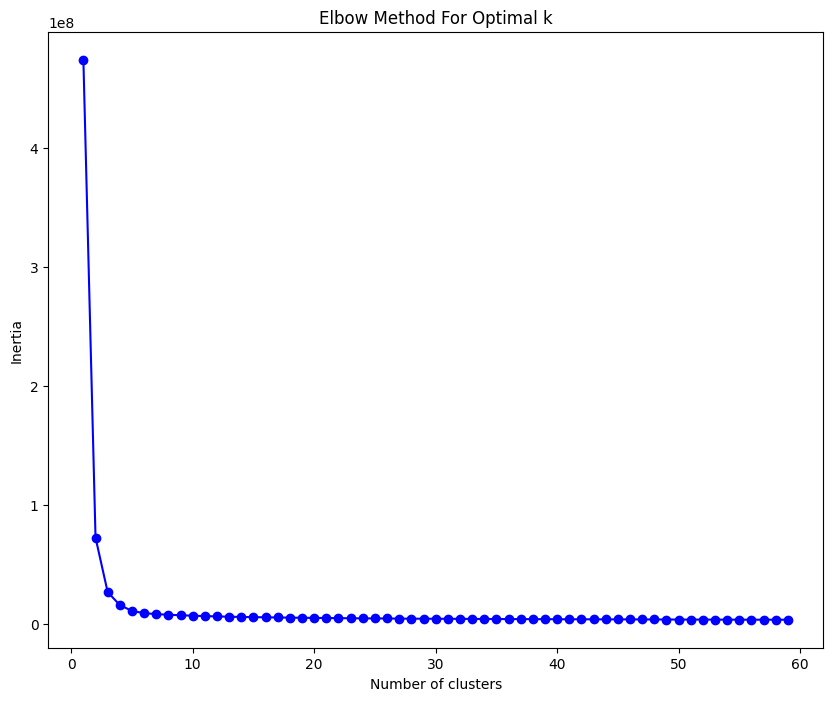

In [78]:
# Elbow method to determine the optimal number of clusters
inertia = []
k_values = range(1, max_number_clusters)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(distancias)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 8))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [79]:
# Based on the plot, set the optimal number of clusters
optimal_clusters = 5  # Choose this based on the elbow plot

# Clusterizar las series de tiempo con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
productos_clientes['cluster'] = kmeans.fit_predict(distancias)

# Guardar las series con su cluster asociado
productos_clientes.to_csv(os.path.join(carpeta_exp, 'series_con_clusters.csv'), index=False)



C:\Users\alope\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [80]:
# Calcular la serie media para cada cluster y guardar
cluster_series_mean = {}

for cluster in productos_clientes['cluster'].unique():
    series_cluster = productos_clientes[productos_clientes['cluster'] == cluster]
    combined_series = []

    for _, row in series_cluster.iterrows():
        product_id = row['product_id']
        customer_id = row['customer_id']
        serie = ventas_producto_mes_sampling[(ventas_producto_mes_sampling['product_id'] == product_id) &
                                             (ventas_producto_mes_sampling['customer_id'] == customer_id)]
        combined_series.append(serie['tn'].values)
    
    # Calcular la media de las series en el cluster
    combined_series = np.array(combined_series)
    mean_series = np.mean(combined_series, axis=0)
    cluster_series_mean[cluster] = mean_series

# Guardar series medias
mean_series_df = pd.DataFrame.from_dict(cluster_series_mean, orient='index')
mean_series_df.index.name = 'cluster'
mean_series_df.to_csv(os.path.join(carpeta_exp, 'series_medias_clusters.csv'))
mean_series_df

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (654,) + inhomogeneous part.

In [23]:
# Graficar clusters junto con las series medias
productos_clientes = pd.read_csv(os.path.join(carpeta_exp, 'series_con_clusters.csv'))
num_clusters = len(productos_clientes['cluster'].unique())

# Borrar gráficos existentes de la carpeta
patron = 'cluster_*.png'
archivos_a_eliminar = glob.glob(os.path.join(carpeta_exp, patron))
for archivo in archivos_a_eliminar:
    os.remove(archivo)

ventas_producto_mes_copia = ventas_producto_mes.copy()

# Graficar clusters
for cluster in range(num_clusters):
    series_cluster = productos_clientes[productos_clientes['cluster'] == cluster]
    plt.figure(figsize=(15, 7))
    for _, row in series_cluster.iterrows():
        product_id = row['product_id']
        customer_id = row['customer_id']
        serie = ventas_producto_mes_sampling[(ventas_producto_mes_sampling['product_id'] == product_id) &
                                             (ventas_producto_mes_sampling['customer_id'] == customer_id)]
        plt.plot(serie['Timestamp'], serie['tn'], color='blue', alpha=0.3)
    
    # Graficar la serie media
    mean_series = mean_series_df.loc[cluster].values
    plt.plot(date_range, mean_series, color='red', linewidth=2, label='Serie Media')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas estandarizadas')
    plt.title(f'Cluster {cluster}')
    plt.legend()
    plt.savefig(os.path.join(carpeta_exp, f'cluster_{cluster}.png'))
    plt.close()